**Competition Goal:** Predict which passengers were transported to an alternate dimension during the Spaceship Titanic's collision with a spacetime anomaly.

**What You Will Learn in This Notebook:**
1. How to explore and understand a dataset before building any model
2. How to clean messy data (handle missing values, encode categories, scale numbers)
3. How to train five different machine learning models and compare them fairly
4. How to pick the best model and generate a Kaggle submission file

**Why This Order Matters:**
Think of machine learning like cooking. You cannot just throw raw ingredients into an oven and hope for the best. You need to wash them, chop them, measure them, and then cook them properly. Each step in this notebook exists for a reason, and skipping any step can ruin the final result. We will explain every step as we go.

---

## Section 1 - Import Libraries

Before writing any analysis code, we load the tools (libraries) we will need.

| Library | Purpose |
|---------|---------|
| pandas | Reading CSVs, manipulating tables of data |
| numpy | Fast math operations on arrays |
| matplotlib / seaborn | Drawing charts and visualizations |
| scikit-learn | Machine learning models, preprocessing, evaluation |
| xgboost | Gradient boosted tree model (often the top performer on tabular data) |

**What happens if you skip this?** Nothing else in the notebook will work. This is like plugging in your appliances before you can use them.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

import time

# Make charts look clean
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All libraries loaded successfully.")

All libraries loaded successfully.


## Section 2 - Load the Data

We have three files from Kaggle:

| File | Rows | Purpose |
|------|------|---------|
| train.csv | ~8700 | Has the answer (Transported column). We learn from this. |
| test.csv | ~4300 | No answer column. We predict on this and submit to Kaggle. |
| sample_submission.csv | ~4300 | Shows the exact format Kaggle expects. |

**Why load all three now?** We need to understand the full picture. The test set may have categories or patterns the training set does not, and vice versa.

In [2]:
# Load the datasets
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test  = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

print(f"Training set   : {train.shape[0]} rows, {train.shape[1]} columns")
print(f"Test set       : {test.shape[0]} rows, {test.shape[1]} columns")
print(f"Submission file: {sample_submission.shape[0]} rows, {sample_submission.shape[1]} columns")

Training set   : 8693 rows, 14 columns
Test set       : 4277 rows, 13 columns
Submission file: 4277 rows, 2 columns


## Section 3 - First Look at the Data

Before doing anything fancy, we simply look at the data. This is like a doctor checking your vitals before running tests. We want to know:
- What columns exist and what type each one is (number vs text)
- How many values are missing
- What the first few rows look like

**What happens if you skip this?** You might build a model on data you do not understand. You could accidentally treat a text column as a number, or miss a column that is 90 percent empty.

In [3]:
print("=== First 5 rows of training data ===")
train.head()

=== First 5 rows of training data ===


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
print("=== Data types and non-null counts ===")
train.info()

=== Data types and non-null counts ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
print("=== Basic statistics for numeric columns ===")
train.describe()

=== Basic statistics for numeric columns ===


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
print("=== Basic statistics for categorical (text) columns ===")
train.describe(include='object')

=== Basic statistics for categorical (text) columns ===


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,False,Ankalik Nateansive
freq,1,4602,5439,8,5915,8291,2


## Section 4 - Understand Missing Values

Real-world data is almost never complete. Passengers may not have filled in every field, or the damaged computer system lost some records. We need to know exactly how much is missing and where.

**Why this matters:** Most machine learning algorithms cannot handle empty cells. If we feed them missing data, they will either crash or silently produce garbage predictions.

In [7]:
missing_train = train.isnull().sum()
missing_pct = (missing_train/len(train) *100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_train,
    'Missing Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

              Missing Count  Missing Percentage
HomePlanet              201                2.31
CryoSleep               217                2.50
Cabin                   199                2.29
Destination             182                2.09
Age                     179                2.06
VIP                     203                2.34
RoomService             181                2.08
FoodCourt               183                2.11
ShoppingMall            208                2.39
Spa                     183                2.11
VRDeck                  188                2.16
Name                    200                2.30


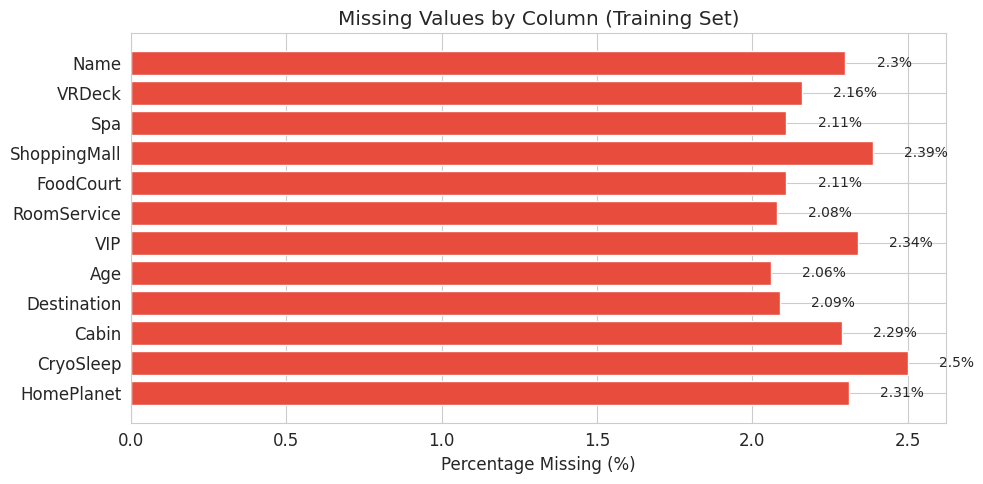

INSIGHT: Most columns have roughly 2% missing data. This is manageable.
The Cabin column is especially important because we can extract deck and side from it.


In [8]:
# Visualize missing values
fig, ax = plt.subplots(figsize=(10, 5))
cols_with_missing = missing_df[missing_df['Missing Count'] > 0].index
colors = ['#e74c3c' if pct > 2 else '#f39c12' for pct in missing_df.loc[cols_with_missing, 'Missing Percentage']]
bars = ax.barh(cols_with_missing, missing_df.loc[cols_with_missing, 'Missing Percentage'], color=colors)
ax.set_xlabel('Percentage Missing (%)')
ax.set_title('Missing Values by Column (Training Set)')
for bar, val in zip(bars, missing_df.loc[cols_with_missing, 'Missing Percentage']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            f'{val}%', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('chart_01_missing_values.png', dpi=150, bbox_inches='tight')
plt.show()
print("INSIGHT: Most columns have roughly 2% missing data. This is manageable.")
print("The Cabin column is especially important because we can extract deck and side from it.")

## Section 5 - Explore the Target Variable

The target variable is `Transported` - the thing we are trying to predict. It is a binary column: True (the passenger was transported) or False (they were not).

**Why check this first?** If the target is heavily imbalanced (e.g., 95% False and 5% True), we would need special techniques. A model could just predict "False" every time and get 95% accuracy while being completely useless.

Transported
True     4378
False    4315
Name: count, dtype: int64


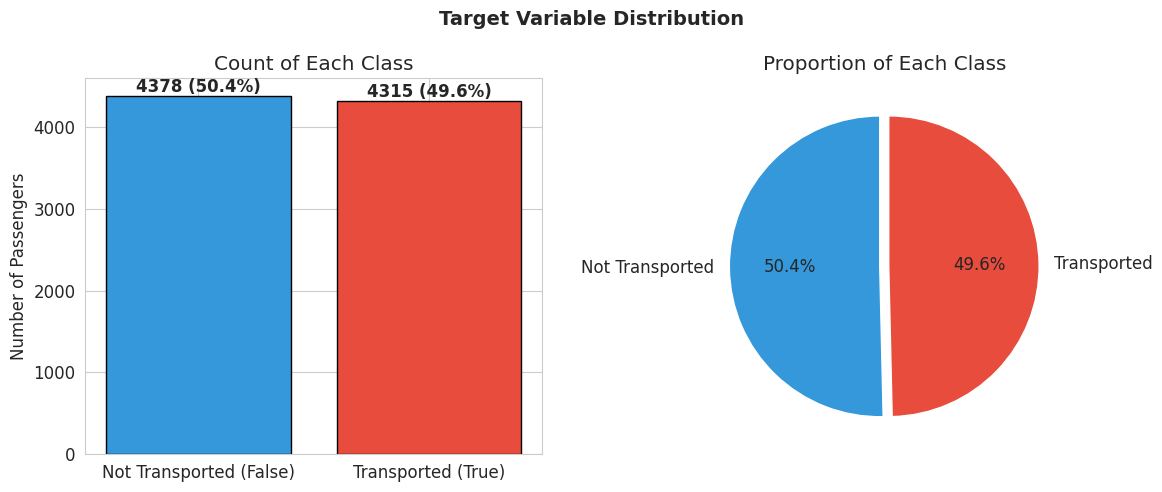

INSIGHT: The classes are almost perfectly balanced (~50/50).
This is great news - we do not need to worry about class imbalance techniques.


In [9]:
# Check the balance of the target
target_counts = train['Transported'].value_counts()
target_pct = train['Transported'].value_counts(normalize=True) * 100

print(target_counts)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
colors = ['#3498db', '#e74c3c']
axes[0].bar(['Not Transported (False)', 'Transported (True)'],
            target_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Count of Each Class')
axes[0].set_ylabel('Number of Passengers')
for i, (count, pct) in enumerate(zip(target_counts.values, target_pct.values)):
    axes[0].text(i, count + 50, f'{count} ({pct:.1f}%)', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=['Not Transported', 'Transported'],
            autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.03, 0.03))
axes[1].set_title('Proportion of Each Class')

plt.suptitle('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_02_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("INSIGHT: The classes are almost perfectly balanced (~50/50).")
print("This is great news - we do not need to worry about class imbalance techniques.")

## Section 6 - Explore Categorical Features

Categorical features are columns with text values (like planet names or True/False). Let us see what unique values each one has and how they relate to the target.

**Why this matters:** Some categories might be strongly linked to being transported. For example, maybe passengers from a specific planet are more likely to be transported. These patterns are gold for our models.

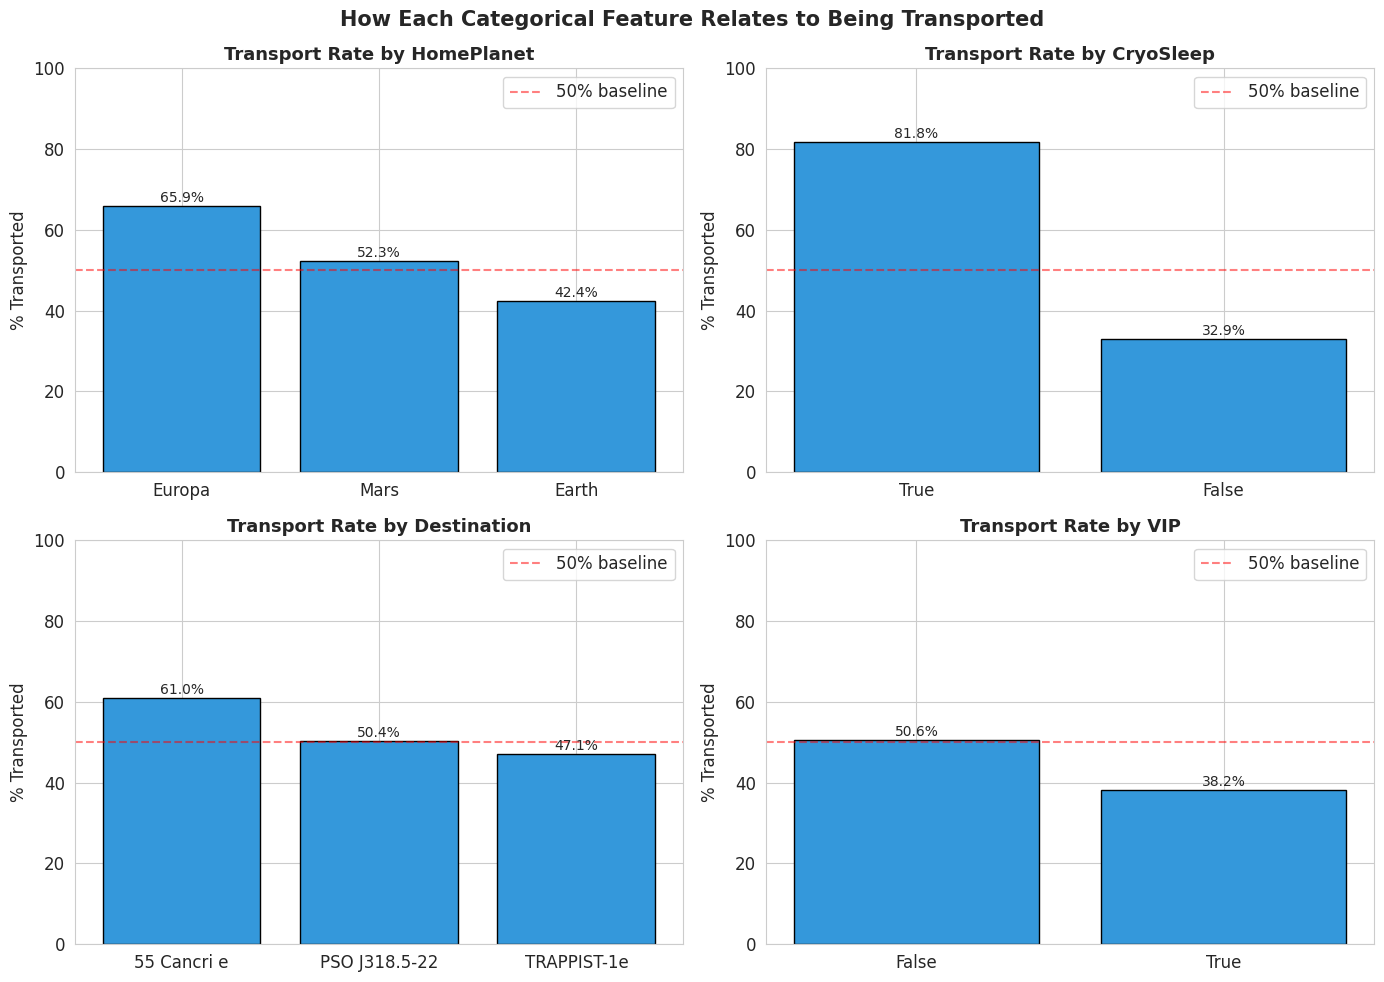

In [10]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Calculate transport rate for each category
    ct = train.groupby(col)['Transported'].mean().sort_values(ascending=False)
    bars = axes[i].bar(ct.index.astype(str), ct.values * 100, color='#3498db', edgecolor='black')
    axes[i].set_title(f'Transport Rate by {col}', fontsize=13, fontweight='bold')
    axes[i].set_ylabel('% Transported')
    axes[i].set_ylim(0, 100)
    axes[i].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% baseline')
    axes[i].legend()
    for bar, val in zip(bars, ct.values * 100):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                     f'{val:.1f}%', ha='center', fontsize=10)

plt.suptitle('How Each Categorical Feature Relates to Being Transported',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_03_categorical_vs_target.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
print("KEY INSIGHTS:")
print("- CryoSleep is the STRONGEST predictor: ~81% of cryosleep passengers were transported.")
print("- HomePlanet matters: Europa passengers are transported more often than Earth passengers.")
print("- VIP passengers are LESS likely to be transported.")
print("- Destination has a moderate effect: 55 Cancri e passengers are transported more often.")

KEY INSIGHTS:
- CryoSleep is the STRONGEST predictor: ~81% of cryosleep passengers were transported.
- HomePlanet matters: Europa passengers are transported more often than Earth passengers.
- VIP passengers are LESS likely to be transported.
- Destination has a moderate effect: 55 Cancri e passengers are transported more often.


## Section 7 - Explore Numeric Features

Numeric features are columns with numbers (like Age, RoomService spending, etc.). We want to understand their distributions and how they relate to the target.

**Why this matters:** If spending patterns differ between transported and non-transported passengers, our models can use that information. Also, if a numeric column has extreme outliers, it might confuse certain algorithms.

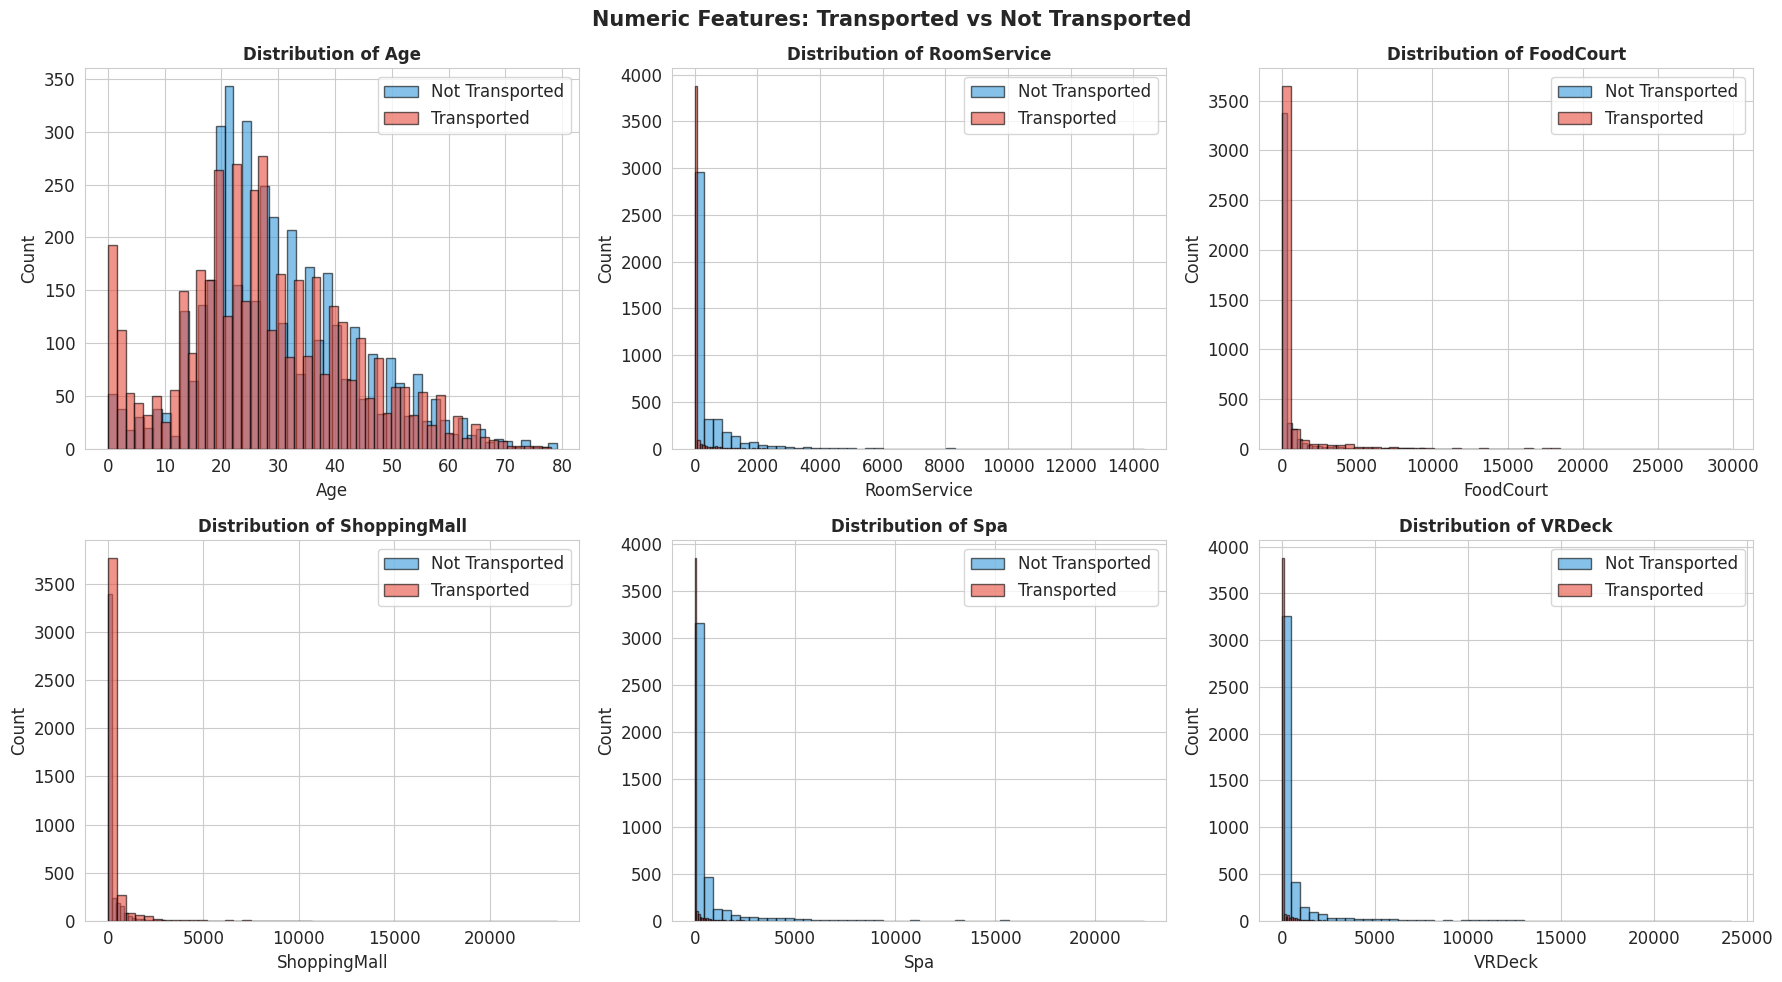

In [12]:
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    # Separate by target
    transported = train[train['Transported'] == True][col].dropna()
    not_transported = train[train['Transported'] == False][col].dropna()

    axes[i].hist(not_transported, bins=50, alpha=0.6, label='Not Transported',
                 color='#3498db', edgecolor='black')
    axes[i].hist(transported, bins=50, alpha=0.6, label='Transported',
                 color='#e74c3c', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.suptitle('Numeric Features: Transported vs Not Transported', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_04_numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
print("KEY INSIGHTS:")
print("- Spending columns (RoomService, FoodCourt, etc.) are heavily right-skewed.")
print("  Most passengers spent 0, but a few spent thousands.")
print("- Transported passengers tend to have LOWER spending across all amenities.")
print("  This makes sense: cryosleep passengers cannot spend, and they are transported more.")
print("- Age shows a slight pattern: younger passengers seem slightly more likely to be transported.")

KEY INSIGHTS:
- Spending columns (RoomService, FoodCourt, etc.) are heavily right-skewed.
  Most passengers spent 0, but a few spent thousands.
- Transported passengers tend to have LOWER spending across all amenities.
  This makes sense: cryosleep passengers cannot spend, and they are transported more.
- Age shows a slight pattern: younger passengers seem slightly more likely to be transported.


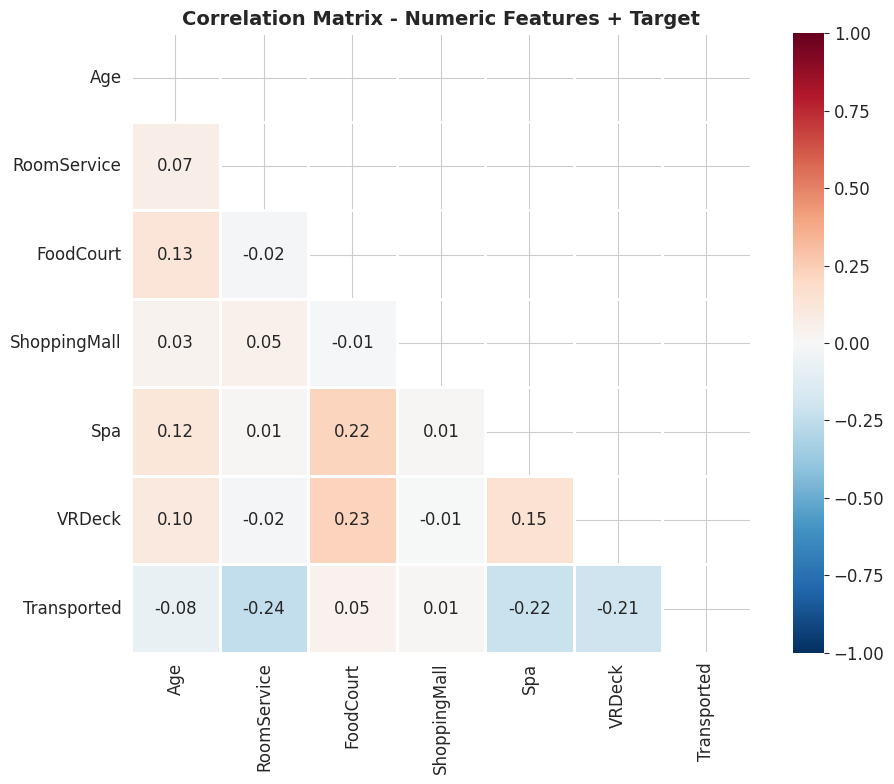

In [14]:
# Correlation heatmap of numeric features with the target
numeric_for_corr = train[numeric_cols + ['Transported']].copy()
numeric_for_corr['Transported'] = numeric_for_corr['Transported'].astype(int)
corr_matrix = numeric_for_corr.corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=1, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Correlation Matrix - Numeric Features + Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_05_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
print("KEY INSIGHTS:")
print("- Spa and VRDeck have the strongest NEGATIVE correlation with Transported.")
print("  Meaning: the more you spend on Spa/VRDeck, the LESS likely you are transported.")
print("- RoomService also negatively correlates with Transported.")
print("- No two features are extremely correlated with each other (no multicollinearity problem).")

KEY INSIGHTS:
- Spa and VRDeck have the strongest NEGATIVE correlation with Transported.
  Meaning: the more you spend on Spa/VRDeck, the LESS likely you are transported.
- RoomService also negatively correlates with Transported.
- No two features are extremely correlated with each other (no multicollinearity problem).
